# VMG_FACENET
****BIOFACENET Model implementation in Pytorch****  
The source code of paper: Deep Biophysical Face Image Interpretation  
Paper Source: https://arxiv.org/pdf/1908.10578.pdf  
Code Source in MATLAB: https://github.com/ssma502/BioFaces


The model was trained using Nvidia GPU using the Jupyter notebook. Lower batch size if GPU memory is being limited. Typically, only parameters in cell 3 have to be modified.
Libraries used are in cell 2, please download them. For Pytorch I have used this command
"conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch"


A parent folder/directory to store the models that we train has to be created using the follow steps  
 
•	Create a directory of your choice - This is your parentpath   
• Open **BioFaceNet_Pytorch.ipynb** in Jupyter Notebook  
• Libraries used are in cell 2, please download them  
•	Copy the parent directory path to _parentpath_ variable in cell 3, path should be in linux format with '/'  
•	Copy the **matFiles** folder from the GitHub to inside the parent folder  
•	Copy the **modelParameters** folder from the GitHub to inside the parent folder   
•	To run prediction using trained model, download this file from google drive https://drive.google.com/drive/folders/1rPLU3Z_r6ZztwBH3eonlFEAV6qiQZd7h?usp=sharing. Place it inside    the modelParameters folder  
•	In cell 3 of the jupyter notebook, Set _DatasetAvailable = 0_ if you want to download the dataset else set _DatasetAvailable = 1_ if it has been downloaded to prevent repeated downloads every time the code is being run (Set _DatasetAvailable_ = 0 to initially download and then make it to 1)  


**Training the model**  
If you wish to simply test the model , skip running the cell no 28 for training. Set _ModelAvailable_ = 0 to train the model from scratch, for every 5 epochs the model parameters will be saved to modelsavepath folder   

**Testing the model**  
Make sure the variable parameterpath has the model file inside modelsavepath folder for testing  
Set _ModelAvailable_ = 1  
Steps:  
   * Run cells 1 to 27

  * 27th cell  contains
    “makefolder(DatasetAvailable,Modelavailable)  
    DownloadData(DatasetAvailable)  
    dataset = CelebA(filename)”  

  * Skip the 28th  cell  
  * Run 29th cell  ,it contains
    “trypredict(parameterpath,dataset.images[103:108],dataset.actualmasks[103:108])”
    
  * To predict use the trypredict function in cell 29, specify the indices in the testing set images and testing masks. ( Input images and masks have 4 dimensions, so if you wish     to  use a single image you will have to unsqueeze)
  * Run cells 30 and 31 for edited maps

**Editing the image**  
Setting _fmel_change_ to a value will add to the melanin map   
Setting _fblood_change_ to a value will add to the haemoglobin map  


In [6]:
import gdown
import os
import numpy as np
import os
import shutil
from scipy.io import loadmat
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.decomposition import PCA
import h5py
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings("ignore")

In [7]:
#parameters
parentpath ="C:/Users/test/Music/VMG_FACENET-main" #parent path replace "\" with "/" 
image_no = 9000 #no of images to train
B =25 #BatchSize
num_epochs = 100;
modelsavepath = os.path.join(parentpath,'modelParameters/') #create
Datasetpath = os.path.join(parentpath,'Dataset') #create if you have the dataset and place the dataset here
matdir = os.path.join(parentpath,'matFiles') #create and place matFiles Dir from Github
clonedir = os.path.join(parentpath,'numpyFiles') 
parameterpath = os.path.join(modelsavepath,'100.pth') # to test the model, this path has the model parameters to be loaded after training 
filename = os.path.join(Datasetpath,'celebA.hdf5') #filename of the dataset

DatasetAvailable =0  # 1 if available inside the Dataset Folder else 0
Modelavailable=1 # 1 if available inside the modelParameter folder else 0

fmel_change = 0 #change melanin map
fblood_change = 0 #change haemoglobin map






In [8]:
#Check if nvidia gpu is available for training
torch.cuda.is_available()

True

In [9]:
def makefolder(DatasetAvailable,modelavailable):
  if not DatasetAvailable ==1:
        if os.path.exists(Datasetpath):
          shutil.rmtree(Datasetpath, ignore_errors=False, onerror=None)
        os.mkdir(Datasetpath)
  if(modelavailable!=1): 
     if os.path.exists(modelsavepath):
        shutil.rmtree(modelsavepath, ignore_errors=False, onerror=None)
     os.mkdir(modelsavepath)
  if os.path.exists(clonedir):
      shutil.rmtree(clonedir, ignore_errors=False, onerror=None)
  os.mkdir(clonedir)
 
 

In [10]:

class CelebA(Dataset):
  def __init__(self, path):
    h5 = h5py.File(filename,'r')
    keys1 = h5.keys()
    data = torch.tensor(list(h5[list(keys1)[0]][: image_no+10])).float()
    #data = h5[list(keys1)[0]]
    #data = torch.tensor(data)
    self.testimages = data[image_no :image_no+200,0:3].float()
    self.testmasks = data[ image_no :image_no+200, 6].unsqueeze(1).float()
    self.images = data[ :image_no, 0:3].float()
    self.actualmasks = data[ :image_no, 6].unsqueeze(1).float()
    self.actualshading = data[ :image_no,4].unsqueeze(1).float()
  
  def __getitem__(self, index):
     return self.images[index],self.actualshading[index],self.actualmasks[index]
  
  def __len__(self):
    return (self.images.shape[0])



In [11]:
# DownloadData() -> use to download dataset to Datasetpath
def DownloadData(DatasetAvailable):
  
  if not DatasetAvailable == 1 :
    url = "https://drive.google.com/uc?id=1puzmuG_zA9u7FdNT3RUabLRmP9A-hHBd"
    #if os.path.exists(Datasetpath):
      #shutil.rmtree (Datasetpath, ignore_errors=False, onerror=None)
    #os.mkdir(Datasetpath)
    os.chdir(Datasetpath)
    output = "celebA.hdf5"
    gdown.download(url, output, quiet=False)






In [12]:
def mat_to_npy(B,matdir,clonedir):
 
#-----------------------------------------------------------------------
  for fil in os.listdir(matdir):
 
  #  print(fil)
    loadmat_path = os.path.join(matdir,fil)
    data= loadmat(loadmat_path)
    matname = list(data.keys())[3]
    #print(matname)
    matvalue = data[matname]
    #print(matvalue.shape)
    savedir = os.path.join(clonedir ,fil[ :-4])
    
    np.save(savedir,matvalue)
    # changes needed , norm to be calculated Test loading of npy files
#------------------------------------------------------------------------------------
  illumD = np.load(os.path.join(clonedir,'illumDmeasured.npy'))
  illumD = torch.from_numpy(illumD)
  illumD = illumD.permute(1,0).unsqueeze(0).unsqueeze(0)
  illumDNorm = torch.zeros_like(illumD)
  for i in range(0,22):
    illumDNorm[0,0,:,i] = illumD[0,0,:,i]/torch.sum(illumD[0,0,:,i]);
  #print(illumD.shape)

  illumA = np.load(os.path.join(clonedir,'illumA.npy'))
  illumA = torch.from_numpy(illumA)
  illumA = illumA/torch.sum(illumA)
  illumA = illumA.unsqueeze(-1)
  illumA = illumA.repeat(1,1,1,B)
  #print(illumA.shape)

  illF = np.load(os.path.join(clonedir,'illF.npy'))
  illF = torch.from_numpy(illF)
  illF = illF.unsqueeze(0)
  illumFNorm = torch.zeros_like(illF)
  for i in range(0,12):
    illumFNorm[0,0,:,i] = illF[0,0,:,i]/torch.sum(illF[0,0,:,i]);

  #print(illF.shape)

  Newskincolour = np.load(os.path.join(clonedir,'Newskincolour.npy'))
  Newskincolour = torch.from_numpy(Newskincolour)
  Newskincolour = Newskincolour.repeat(B,1,1,1)
  Newskincolour  = torch.permute(Newskincolour,(0,3,1,2))
  #print(Newskincolour.shape) #10, 33, 256, 256

  rgbCMF1 = np.load(os.path.join(clonedir,'rgbCMF1.npy'))
  rgbCMF1 = torch.from_numpy(rgbCMF1)
  rgbCMF2 = np.load(os.path.join(clonedir,'rgbCMF2.npy'))
  rgbCMF2 = torch.from_numpy(rgbCMF2)
  rgbCMF3 = np.load(os.path.join(clonedir,'rgbCMF3.npy'))
  rgbCMF3 = torch.from_numpy(rgbCMF3)

  rgbCMF = torch.stack((rgbCMF1,rgbCMF2,rgbCMF3))
  #print(rgbCMF.shape) # 3, 33, 28

  Tmatrix= np.load(os.path.join(clonedir,'Tmatrix.npy'))
  Tmatrix = torch.from_numpy(Tmatrix)
  Tmatrix= torch.permute(Tmatrix.unsqueeze(0), (0,3,1,2))
  Tmatrix = Tmatrix.repeat(B,1,1,1) # 10, 9, 128, 128
  #print(Tmatrix.shape)
  return (illumA,illumDNorm,illumFNorm,Newskincolour,rgbCMF,Tmatrix)




    
    

In [13]:

def camera_and_lighting(in_c,out_c):
  conv = nn.Sequential(
			nn.Conv2d(in_c, in_c, kernel_size = 3, stride =1, padding = 'same', ),
			nn.BatchNorm2d(in_c),
			nn.ReLU(inplace = True),
			nn.Conv2d(in_c, in_c, kernel_size = 1, stride = 1, padding = 'same',),
			nn.BatchNorm2d(in_c),
			nn.ReLU(inplace = True),
      nn.Flatten(),
      nn.Linear( 8192,out_c)
    )
  
  return conv

def TripleConv(in_c,out_c,kernel_size):

  conv = nn.Sequential(
			nn.Conv2d(in_c, out_c, kernel_size = kernel_size, stride =1, padding = 1,  bias = False),
			nn.BatchNorm2d(out_c),
			nn.ReLU(inplace = True),
			nn.Conv2d(out_c, out_c, kernel_size = kernel_size, stride = 1, padding = 1, bias = False),
			nn.BatchNorm2d(out_c),
			nn.ReLU(inplace = True),
			nn.Conv2d(out_c, out_c, kernel_size = kernel_size, stride = 1, padding = 1, bias = False),
			nn.BatchNorm2d(out_c),
			nn.ReLU(inplace = True)
		)
  return conv
  


class FaceNetEncoder(nn.Module):
 def __init__(self):
   super(FaceNetEncoder,self).__init__()
   self.maxpool = nn.MaxPool2d(kernel_size = 2,stride = 2)
   self.convdown1 = TripleConv(3,32,3)
   self.convdown2 = TripleConv(32, 64, 3)
   self.convdown3 = TripleConv(64,128,3)
   self.convdown4 = TripleConv(128,256,3)
   self.convdown5 = TripleConv(256,512,3)
   self.float()
 
 def forward(self,image):
   #encoder
   x1 = self.convdown1(image)
   x2 = self.maxpool(x1)
   x3 = self.convdown2(x2)
   x4 = self.maxpool(x3)
   x5 = self.convdown3(x4)
   x6 = self.maxpool(x5)
   x7 = self.convdown4(x6)
   x8 = self.maxpool(x7)
   x9 = self.convdown5(x8)
   return x1,x3,x5,x7,x9

class FaceNetDecoder(nn.Module):
 def __init__(self):
     super(FaceNetDecoder,self).__init__()
     self.transconv1 = nn.ConvTranspose2d(512, 256, 2, stride = 2)
     self.transconv2 = nn.ConvTranspose2d(256, 128, 2, stride = 2)
     self.transconv3 = nn.ConvTranspose2d(128, 64, 2, stride = 2)
     self.transconv4 = nn.ConvTranspose2d(64, 32, 2, stride = 2)
     self.conv1 = TripleConv(512,256,3)
     self.conv2 = TripleConv(256,128,3)
     self.conv3 = TripleConv(128,64,3)
     self.conv4 = TripleConv(64,32,3)
     self.out = nn.Conv2d(32,1,1,stride = 1)
     self.float()



 def forward(self,x1,x3,x5,x7,x9):
    #decoder
    x10 = self.transconv1(x9)
    x11 = self.conv1(torch.cat([x10,x7],1))# concatenate feature maps from encoder as input to TripleConv
    x12 = self.transconv2(x11)
    x13 = self.conv2(torch.cat([x12,x5],1))# concatenate feature maps from encoder as input to TripleConv
    x14 = self.transconv3(x13)
    x15 = self.conv3(torch.cat([x14,x3],1))# concatenate feature maps from encoder as input to TripleConv
    x16 = self.transconv4(x15)
    x17 = self.conv4(torch.cat([x16,x1],1))
    x18 = self.out(x17)
    return x18



class MultiDecoder(nn.Module):
  def __init__(self):
   super(MultiDecoder,self).__init__()
   self.lighting_dim = 15;
   self.b_dim  =2;
   self.encoder = FaceNetEncoder()
   self.decoder1 = FaceNetDecoder()
   self.decoder2 = FaceNetDecoder()
   self.decoder3 = FaceNetDecoder()
   self.decoder4 = FaceNetDecoder()
   self.cam_lighting = camera_and_lighting(512,self.lighting_dim+self.b_dim)
   self.float()

  def forward(self,image):
     skipl1,skipl2,skipl3,skipl4,low_res = self.encoder(image)
     fmel = self.decoder1(skipl1,skipl2,skipl3,skipl4,low_res)
     fblood = self.decoder2(skipl1,skipl2,skipl3,skipl4,low_res)
     shading = self.decoder3(skipl1,skipl2,skipl3,skipl4,low_res)
     specmask = self.decoder4(skipl1,skipl2,skipl3,skipl4,low_res)
     #print(low_res.shape)
     cam_lighting_params = self.cam_lighting(low_res)
     b = cam_lighting_params[:,self.lighting_dim :]
     lightingparameters = cam_lighting_params[:,:self.lighting_dim]
     return fmel,fblood,shading,specmask,lightingparameters,b


def ScalingNet(fmel,fblood,specmask,Shading,lightingweights,b,bSize):
   #inputs
   #fmel : B x 1 x 64 x 64
   #fblood : B x 1 x 64 x 64
   #specmask: B x 1 x 64 x 64
   #Shading : B x 1 x 64 x 64
   # lightingweights = B x 15
   #b: B x 2
   #bSize : 2

   #output
   #     weightA    : B x 1 x 1 x 1 
   #     weightD    : B x 1 x 1 x 1
   #      CCT        : B x 1 x 1 x 1
   #     Fweights      : B x 12 x 1 x 1 
   #      b            : B x 2
   #     BGrid         : B x 1 x 1 x 2
   #     fmel ,fblood,Shading,specmask  :  B x 1 x H x W      
   
    CCT = lightingweights[:,14]
    SM = nn.Softmax(dim=1)
    lightingweights =  SM(lightingweights[:,:14])
    weightA = lightingweights[:,0]
    weightD = lightingweights[:,1]
    Fweights = lightingweights[:,2:]
    Sig = nn.Sigmoid()
    CCT = 21* Sig(CCT) + 1
    b = 6*Sig(b) - 3
    nbatch = lightingweights.shape[0]
    BGrid = torch.reshape(b,(bSize,1,1,nbatch))
    BGrid = BGrid /3
    fmel = 2*Sig(fmel) -1 
    fblood = 2*Sig(fblood) -1 
    specmask = torch.exp(specmask)
    Shading = torch.exp(Shading)
    #changing shapes
    weightA = weightA.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    weightD = weightD.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    CCT = CCT.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    Fweights = Fweights.unsqueeze(-1).unsqueeze(-1)
    BGrid = torch.permute(BGrid,(3,1,2,0))


    return weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask






 
   

In [14]:
def illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm):
  
#     weightA    : B x 1 x 1 x 1 
#     weightD    : B x 1 x 1 x 1
#     CCT        : B x 1 x 1 x 1
#     Fweights      : B x 12 x 1 x 1 
#     illumA     : 1 x 1 x 33 x B
#     illumDNorm : 1 x 1 x 33 x 22
#     illumFNorm : 1 x 1 x 33 x 12
#       e         : Bx33x1x1

  illumA = illumA.permute(3,2,0,1)
  illumDNorm = illumDNorm.permute(2,3,0,1)
  illumDNorm = torch.squeeze( illumDNorm)
  weightD = weightD.squeeze(3).squeeze(2)
  CCT = CCT.squeeze(3).squeeze(2)
  illumFNorm = illumFNorm.permute(0,2,3,1)
  Fweights = Fweights.permute(2,3,1,0) 
  CCT = torch.round(CCT)
  CCT = CCT.long()

  illuminantA = illumA*weightA #shape Bx33x1x1
  illD = illumDNorm[:,CCT]
  illD = illD.squeeze(2)
  #print(illD.shape)
  illD = illD.permute(1,0)
  illuminantD = illD *weightD;# B x33
  #illuminatD = illuminatD.permute(1,0)# 33 x B
  illuminantD = illuminantD.unsqueeze(-1).unsqueeze(-1)#  B x 33 x1 x1
  illuminantF = illumFNorm*Fweights #1 x 33 x 12 x B
  illuminantF = torch.sum(illuminantF,2)
  illuminantF = illuminantF.unsqueeze(2)
  illuminantF = illuminantF.permute(3,1,2,0)#shape Bx33x1x1
  

  e = illuminantA + illuminantD +illuminantF
  esum = torch.sum(e,1)
  esum = esum.unsqueeze(1)
  e = e/esum #shape Bx33x1x1
  return e



In [15]:
def CameraSensitivityPCA(cmf):

 y = np.zeros((99,28))
 device2 =torch.device('cpu')
 cmf = cmf.to(device2) 
 redS = cmf[0 ,:,:].numpy()
 greenS = cmf[1 ,:,:].numpy()
 blueS = cmf[2,:,:].numpy()

 for i in range(0,28):
   y[:33,i] = redS[ :, i]/np.sum(redS[ : , i],axis = 0)
   y[33:66,i] = greenS[ :, i]/np.sum(greenS[ : , i],axis = 0)
   y[66: ,i] = blueS[ :, i]/np.sum(blueS[ : , i],axis = 0)
 

 pca = PCA()
 # pcaresult = pca.fit(y.T)
 # matlab documentation 
 #[coeff,score,latent,tsquared,explained,mu] = 
 #pca(___) also returns explained, the percentage of the total variance explained by each principal component and mu, the estimated mean of each variable in X.
 pca.fit(y.T)
 mu = pca.mean_
 PC = pca.components_
 EV = pca.explained_variance_[0:2]
 Evdiag = np.diag(np.sqrt(EV))
 PC = np.matmul(PC.T[:,0:2],Evdiag)

 return mu, PC, EV
  






In [16]:
def cameraModel(mu,PC,b,wavelength):
  # wavelength : 33
  #Sr,Sg,Sb   : B x 33 x 1 x 1
  #PC : 99x2
  # b : B x 2
  # mu : 99 x 1 
 b =b.T
 spec_before_relu = torch.matmul(PC, b) + mu   # 99 x B
 Rel = torch.nn.ReLU()
 spec = Rel(spec_before_relu)
 #print(spec.shape)

 Sr = spec[:wavelength,:].T.unsqueeze(-1).unsqueeze(-1)
 Sg = spec[wavelength:2*wavelength, : ].T.unsqueeze(-1).unsqueeze(-1)
 Sb=  spec[2*wavelength:, : ].T.unsqueeze(-1).unsqueeze(-1)
 return Sr, Sg, Sb

In [17]:
#BiotoSpectralRef.m
def BiotoSpectralRF(fmel, fblood,Newskincolour):
# Inputs:
#     fmel             : B x 1 x H x W 
#     fblood           : B x 1 x H x W
#     Newskincolour    : B x 33 x 256 x 256 
#  Output:
#     R_total          : B x 33 x H x W 
  BiophysicalMaps = torch.cat((fmel, fblood),1)
  #print(BiophysicalMaps.shape)
  BiophysicalMaps =BiophysicalMaps.permute(0, 2, 3, 1)
  R_total = torch.nn.functional.grid_sample(Newskincolour,BiophysicalMaps,'bilinear',align_corners=False)
  return R_total

In [18]:
def computelightcolour(e, Sr, Sg, Sb):
  #Sr,Sg,Sb   : B x 33 x 1 x 1
  #       e         : Bx33x1x1
  #lightcolour : B x 3 x 1 x 1

  Sr =torch.sum(Sr* e,1)
  Sg =torch.sum(Sg* e,1)
  Sb = torch.sum(Sb* e,1)
  lightcolour = torch.stack((Sr,Sg,Sb))
  lightcolour = torch.permute(lightcolour, (1,0,2,3))
    #print(lightcolour.shape)
  return lightcolour

In [19]:
def computeSpecularities(specmask, lightcolour):
  #lightcolour : B x 3 x 1 x 1
  #specmask     : B x 1 x H x W 
  #Specularities : B x 3 x H x W 

  #lightcolour = lightcolour.unsqueeze
  Specularities  = specmask * lightcolour
  return Specularities

In [20]:
def ImageFormation(R_total, Sr, Sg, Sb, e, Specularities, Shading):
  # Sr,Sg,Sb :B x 33 x 1 x 1
  # R_total: Bx33xHxW
  # e: Bx  33 x 1 x 1
  # R_total       : B x 33 x H x W   
  # specularities: Bx3xHxW
  # shading: Bx1xHxW
  # rawAppearance, diffuseAlbedo : B x 3 x H x W
  spectraRef = R_total * e # Bx 33 x H x w
  rChannel = torch.sum(spectraRef * Sr,1)
  gChannel = torch.sum(spectraRef * Sg,1)
  bChannel= torch.sum(spectraRef * Sb,1)
  diffuseAlbedo= torch.stack((rChannel, gChannel, bChannel),1) # B x 3 x H x W
  ShadedDiffuse = diffuseAlbedo * Shading
  rawAppearance = ShadedDiffuse + Specularities          # B x 3 x H x W 
  return rawAppearance, diffuseAlbedo

In [21]:
def WhiteBalance(rawAppearance, lightcolour):
  # Inputs:
  # rawAppearance : B x3 x H x W
  #lightcolour : B x 3 x 1 x 1
  # Outputs
  #ImwhiteBalanced : B x 3 x H x W 

   WBrCh = rawAppearance[:,0,:,:]/ lightcolour[:,0,:,:]
   WBgCh = rawAppearance[:,1,:,:]/ lightcolour[:,1,:,:]
   WBbCh = rawAppearance[:,2,:,:]/ lightcolour[:,2,:,:]
   #print(WBbCh.shape)
   ImwhiteBalanced =torch.stack((WBrCh,WBgCh,WBbCh),1)
   return ImwhiteBalanced

In [22]:
def findT(Tmatrix,BGrid):
# Inputs
#   Tmatrix          : B x 9 x 128 x 128
#   BGrid            : B x 1 x 1 x 2 
# Outputs
#  T_RAW2RGB        :  B x 9 x 1 x 1

  T_RAW2XYZ =  nn.functional.grid_sample(Tmatrix,BGrid, mode='bilinear',align_corners=False)
  return T_RAW2XYZ


In [23]:
#RawTosRGB
def fromRawTosRGB(imWB,T_RAW2XYZ):
  # Inputs:
  #   ImwhiteBalanced: B X 3 X H X W  
  #   T_RAW2RGB  :  B x9 x 1 x 1
  # Output:
  #   sRGBim : B X 3 X H X W

  #Ix : B x H x W
  Ix = T_RAW2XYZ[:,0,:,:] * imWB[:,0,:,:] + T_RAW2XYZ[:,3,:,:] * imWB[:,1,:,:] + T_RAW2XYZ[:,6,:,:] * imWB[:,2,:,:] 
  Iy = T_RAW2XYZ[:,1,:,:] * imWB[:,0,:,:] + T_RAW2XYZ[:,4,:,:] * imWB[:,1,:,:] + T_RAW2XYZ[:,7,:,:] * imWB[:,2,:,:] 
  Iz = T_RAW2XYZ[:,2,:,:] * imWB[:,0,:,:] + T_RAW2XYZ[:,5,:,:] * imWB[:,1,:,:] + T_RAW2XYZ[:,8,:,:] * imWB[:,2,:,:] 
  Ixyz = torch.stack([Ix,Iy, Iz], dim=1)
  #print(Ixyz.shape)

  Txyzrgb  = torch.tensor([3.2406, -0.9689, 0.0557, -1.5372, 1.8758, -0.2040, -0.4986, 0.0415, 1.057])
  
  R= Txyzrgb[0] * Ixyz[:,0,:,:] + Txyzrgb[3] * Ixyz[:,1,:,:] + Txyzrgb[6] * Ixyz[:,2,:,:]  # R
  G = Txyzrgb[1] * Ixyz[:,0,:,:] + Txyzrgb[4] * Ixyz[:,1,:,:] + Txyzrgb[7] * Ixyz[:,2,:,:]  #G
  B = Txyzrgb[2] * Ixyz[:,0,:,:] + Txyzrgb[5] * Ixyz[:,1,:,:] + Txyzrgb[8] * Ixyz[:,2,:,:]# B
  sRGBim = torch.stack([R,G,B], dim=1)
  Rel = nn.ReLU()
  sRGBim =  Rel(sRGBim)
  return sRGBim

In [24]:
# Loss

def lossfun(b,images,actualmasks,actualshading,sRGBim, predictedShading,Specularities):

  blossweight = 1e-4;  
  appweight = 1e-3; 
  Shadingweight = 1e-5; 
  sparseweight = 1e-5

  priorloss = torch.sum(torch.pow(b,2))*blossweight #cameraloss
  
  Mseloss = nn.MSELoss()
  images = images * actualmasks
  sRGBim = sRGBim * actualmasks
  appearanceloss       =  Mseloss(images,sRGBim) *appweight #appearance loss

  sparsityloss = torch.sum(torch.abs(Specularities)) *sparseweight  #L1 sparsity loss

  
  scale = torch.sum((actualshading * predictedShading) * actualmasks)/ torch.sum(torch.pow(predictedShading,2) * actualmasks)
  predictedShading = predictedShading * scale

  actualshading = actualshading * actualmasks
  predictedshading=predictedShading * actualmasks
  shadingloss = Mseloss(actualshading,predictedShading) * Shadingweight #shading loss
  #shadingloss = torch.sum(torch.pow(shadingdiff,2))  
  #print(appearanceloss , priorloss , sparsityloss ,shadingloss)

  return(appearanceloss , priorloss , sparsityloss ,shadingloss)







In [25]:
#training
def trainmodel(B,dataset,num_epochs,matdir,clonedir,model = MultiDecoder()):
  if torch.cuda.is_available():
   device = torch.device('cuda:0')

  else:
    device = torch.device('cpu')

  device2 = torch.device('cpu')

  dataloader = DataLoader(dataset = dataset, batch_size= B,num_workers=0,pin_memory=True,shuffle=True,drop_last=True)
  learning_rate = 1e-5
  total_samples = len(dataset)
  illumA,illumDNorm,illumFNorm,Newskincolour,rgbCMF,Tmatrix = mat_to_npy(B,matdir,clonedir)
  #model = MultiDecoder()
  model.to(device,dtype=torch.float32)

  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
  optimizer.zero_grad()


  illumA = illumA.to(device,dtype=torch.float32)
  illumDNorm = illumDNorm.to(device,dtype=torch.float32)
  illumFNorm= illumFNorm.to(device,dtype=torch.float32)
  Newskincolour = Newskincolour.to(device,dtype=torch.float32)
  rgbCMF = rgbCMF.to(device,dtype=torch.float32)
  Tmatrix = Tmatrix.to(device,dtype=torch.float32)

  for epochs in range(num_epochs):
    epoch_loss =0;
    training_batch = iter(dataloader)
    for i in range(len(dataloader)):
      images,actualshading,actualmasks = next(training_batch)
      images = images.to(device,dtype=torch.float32)
      actualshading = actualshading.to(device,dtype=torch.float32)
      actualmasks= actualmasks.to(device,dtype=torch.float32)
      fmel,fblood,shading,specmask,lightingparameters,b = model(images)
      
      weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask=ScalingNet(fmel,fblood,shading,specmask,lightingparameters,b,2)
      e=illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm)
      mu, PC, EV = CameraSensitivityPCA(rgbCMF)

      mu = torch.from_numpy(mu)
      mu = mu.to(device,dtype = torch.float32)
      mu = mu.unsqueeze(-1)
      PC = torch.from_numpy(PC)
      PC = PC.to(device,dtype=torch.float32)
      EV = torch.from_numpy(EV)
      EV = EV.to(device,dtype=torch.float32)



      Sr, Sg, Sb = cameraModel(mu,PC,b,33)
      R_total = BiotoSpectralRF(fmel, fblood,Newskincolour)
      lightcolour = computelightcolour(e, Sr, Sg, Sb)
      Specularities= computeSpecularities(specmask, lightcolour)
      rawAppearance, diffuseAlbedo =ImageFormation(R_total, Sr, Sg, Sb, e, Specularities, Shading)
      ImwhiteBalanced=WhiteBalance(rawAppearance, lightcolour)
      T_RAW2XYZ =  findT(Tmatrix,BGrid)
      sRGBim = fromRawTosRGB(ImwhiteBalanced,T_RAW2XYZ)
      
      

      
      appearanceloss , priorloss , sparsityloss ,shadingloss = lossfun(b,images,actualmasks,actualshading,sRGBim,Shading,Specularities)
      batch_loss = appearanceloss + priorloss + sparsityloss + shadingloss 
      epoch_loss = epoch_loss + batch_loss
      model.train()
      batch_loss = batch_loss.to(dtype = torch.float32)
      #print(batch_loss.dtype)
      batch_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    print("epochloss", epoch_loss)
    if (epochs+1) % 5 ==0:
     path1 = modelsavepath + str(epochs+1)+'.pth' #use either pth or pt
     #print(path1)
     torch.save(model.state_dict(), path1)

  
  







In [26]:
def load_model(path):
  loaded_model = MultiDecoder()
  loaded_model.load_state_dict(torch.load(path))
  return  loaded_model 

In [27]:
def modeloutput(images,model,path,device):
  B = images.shape[0]
  device2 = torch.device('cpu')
  illumA,illumDNorm,illumFNorm,Newskincolour,rgbCMF,Tmatrix = mat_to_npy(B,matdir,clonedir)
  illumA = illumA.to(device,dtype=torch.float32)
  illumDNorm = illumDNorm.to(device,dtype=torch.float32)
  illumFNorm= illumFNorm.to(device,dtype=torch.float32)
  Newskincolour = Newskincolour.to(device,dtype=torch.float32)
  rgbCMF = rgbCMF  #.to(device,dtype=torch.float32)
  Tmatrix = Tmatrix.to(device,dtype=torch.float32)
 # print("1")

  images = images.to(device,dtype=torch.float32)
  
  fmel,fblood,shading,specmask,lightingparameters,b = model(images)
  fmel = fmel.to(dtype = torch.float32)
  fblood = fblood.to(dtype = torch.float32)
  shading = shading.to(dtype = torch.float32)
  specmask = specmask.to(dtype = torch.float32)
  lightingparameters = lightingparameters.to(dtype = torch.float32)
  b = b.to(dtype = torch.float32)
  weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask=ScalingNet(fmel,fblood,shading,specmask,lightingparameters,b,2)
  
  #Edited maps
  fmel = torch.add(fmel,fmel_change)
  fblood = torch.add(fblood,fblood_change)
  fmel = torch.clamp(fmel, min=-1, max=1)
  fblood = torch.clamp(fblood, min=-1, max=1)

  
  
  e=illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm)
  mu, PC, EV = CameraSensitivityPCA(rgbCMF)
  

  mu = torch.from_numpy(mu)
  mu = mu.to(device)
  mu = mu.unsqueeze(-1)
  PC = torch.from_numpy(PC)
  PC = PC.to(device,dtype=torch.float32)
  EV = torch.from_numpy(EV)
  EV = EV.to(device,dtype=torch.float32)
  



  Sr, Sg, Sb = cameraModel(mu,PC,b,33)
  R_total = BiotoSpectralRF(fmel, fblood,Newskincolour)
  lightcolour = computelightcolour(e, Sr, Sg, Sb)
  Specularities= computeSpecularities(specmask, lightcolour)

    
  rawAppearance, diffuseAlbedo =ImageFormation(R_total, Sr, Sg, Sb, e, Specularities, Shading)
  ImwhiteBalanced=WhiteBalance(rawAppearance, lightcolour)
  T_RAW2XYZ =  findT(Tmatrix,BGrid)
  sRGBim = fromRawTosRGB(ImwhiteBalanced,T_RAW2XYZ)
    
  Specularities2=torch.clone(Specularities).detach()
 # for i in range(Specularities2.shape[0]):
       #for j in range(3):
          #Specularities2[i,j]=torch.div(Specularities2[i,j],torch.max(Specularities2[i,j]))
    
  sRGBim = sRGBim.detach()
  fmel = fmel.detach()
  fblood = fblood.detach()
  Shading = Shading.detach()
  Specularities= Specularities.detach()

  return sRGBim,fmel,fblood,Shading,Specularities2

In [28]:
def plot(images,sRGBim,fmel,fblood,Shading,Specularities,masks,fmel_vmin,fmel_vmax,fblood_vmin,fblood_vmax):
    images=images.unsqueeze(0)
    sRGBim=sRGBim.unsqueeze(0)
    fmel=fmel.unsqueeze(0)
    fblood=fblood.unsqueeze(0)
    
    Shading=Shading.unsqueeze(0)
    Specularities=Specularities.unsqueeze(0)
    masks=masks.unsqueeze(0)
    norm1 = colors.Normalize(-1,1,clip = True)
    norm2 = colors.Normalize(-1,1,clip = True)
    fig = plt.figure(figsize=(30, 30))
    

    for i in range(images.shape[0]):
        fig.add_subplot(i+1,6,1)
        im = torch.permute(images[i],(1,2,0))
        spec = torch.permute(Specularities[i],(1,2,0))
        predictim = torch.permute(sRGBim[i],(1,2,0))
        plt.subplot(i+1,6,1)
        plt.imshow(im)
        fig.add_subplot(i+1,6,2)
        plt.imshow(predictim)
        fig.add_subplot(i+1,6,3)
        
        plt.imshow(fmel[i,0]*masks[i,0],norm = norm1)#,cmap =plt.get_cmap('jet'))
       # print(torch.min((fmel[i,0]*masks[i,0])))
        fig.add_subplot(i+1,6,4)
        plt.imshow(fblood[i,0]*masks[i,0],norm=norm2)#,cmap=plt.get_cmap('jet'))#,cmap=plt.get_cmap('jet'))
        fig.add_subplot(i+1,6,5)
        plt.imshow(Shading[i,0]*masks[i,0],cmap="gray")
        fig.add_subplot(i+1,6,6)
        plt.imshow(spec)
        
    

In [29]:
def trypredict(path,images,masks):
  device2 = torch.device('cpu')


  loaded_model = MultiDecoder()
  loaded_model.load_state_dict(torch.load(path,map_location = device2))
  loaded_model.eval();
  images = images.to(device2,dtype = torch.float32)
  
  
  sRGBim,fmel,fblood,Shading,Specularities=modeloutput(images,loaded_model,path,device2)
  fmel_vmin = torch.min(fmel)
  fmel_vmax = torch.max(fmel)
  fblood_vmin = torch.min(fblood)
  fblood_vmax = torch.max(fblood)


  
  for i in range(images.shape[0]):
      plot(images[i],sRGBim[i],fmel[i],fblood[i],Shading[i],Specularities[i],masks[i],fmel_vmin,fmel_vmax,fblood_vmin,fblood_vmax)



In [30]:
#functions
# trainmodel() model training
# trypredict(path,images) - to test model, images - batch of images,  path - parameterpath
# DownloadData() -> use to download dataset to Datasetpath


In [31]:
makefolder(DatasetAvailable,Modelavailable)
DownloadData(DatasetAvailable)
dataset = CelebA(filename)



Downloading...
From: https://drive.google.com/uc?id=1puzmuG_zA9u7FdNT3RUabLRmP9A-hHBd
To: C:\Users\test\Music\VMG_FACENET-main\Dataset\celebA.hdf5
3.16GB [11:05, 4.76MB/s]


In [29]:
trainmodel(B,dataset,num_epochs,matdir,clonedir)

E:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epochloss tensor(3.7615, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(3.3198, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(3.1150, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(2.8376, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(2.5529, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(2.3562, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(2.2699, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(2.1574, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(2.0867, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(2.0387, device='cuda:0', grad_fn=<AddBackward0>)


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


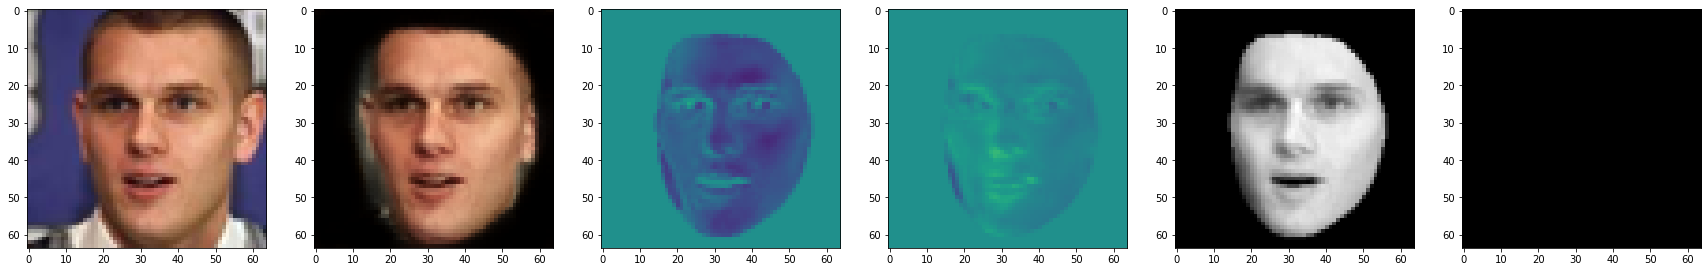

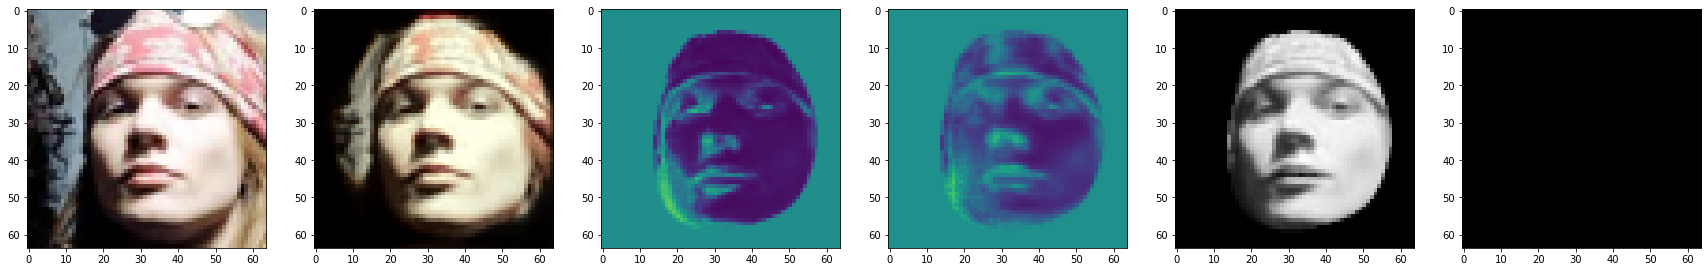

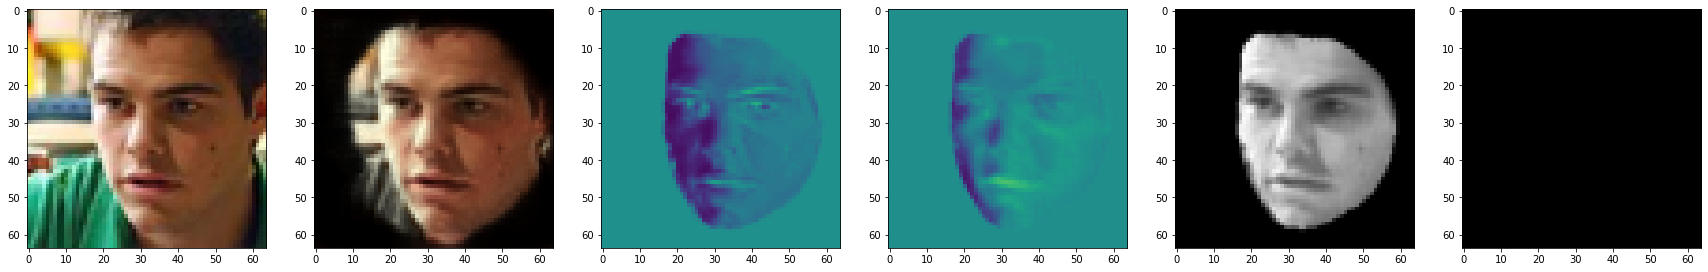

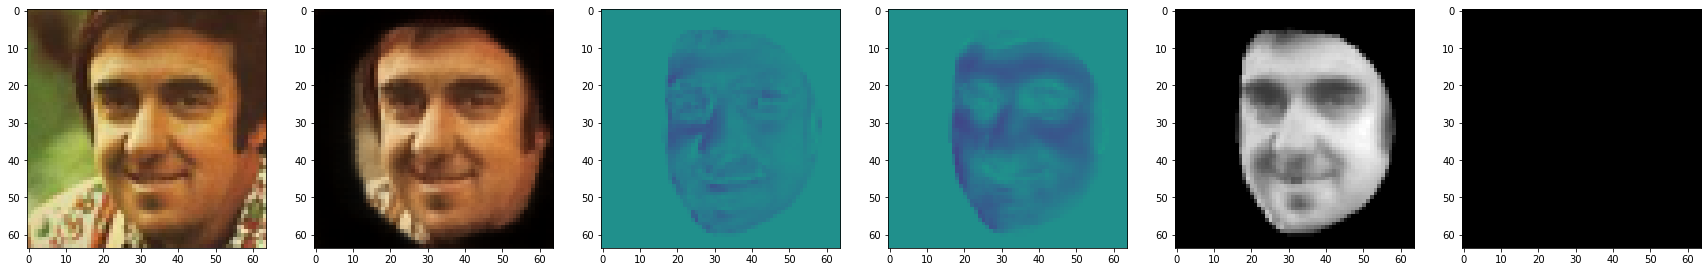

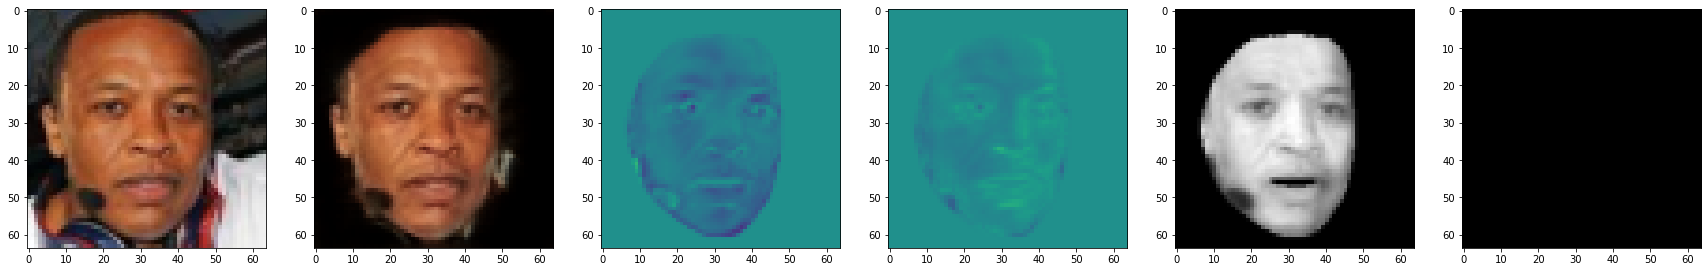

In [126]:
trypredict(parameterpath,dataset.images[103:108],dataset.actualmasks[103:108])

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


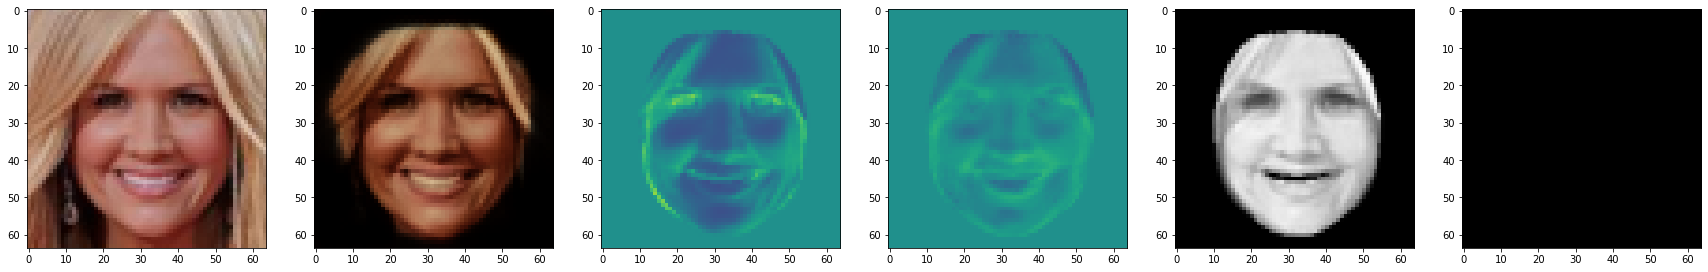

In [119]:
#Edited melanin map
fmel_change = 0.4
fblood_change = 0
trypredict(parameterpath,dataset.images[9:10],dataset.actualmasks[9:10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


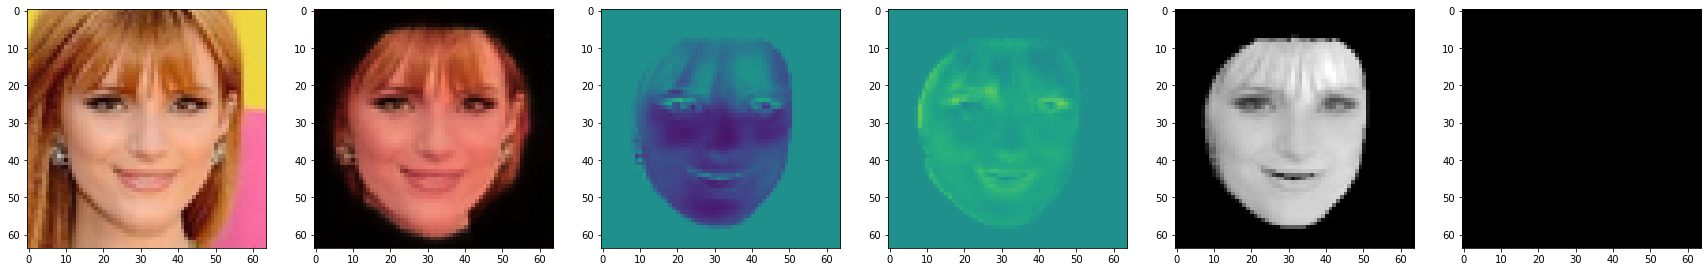

In [130]:
#Edited Haemoglobin map
fmel_change = 0
fblood_change = 0.3
trypredict(parameterpath,dataset.images[8:9],dataset.actualmasks[8:9])

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


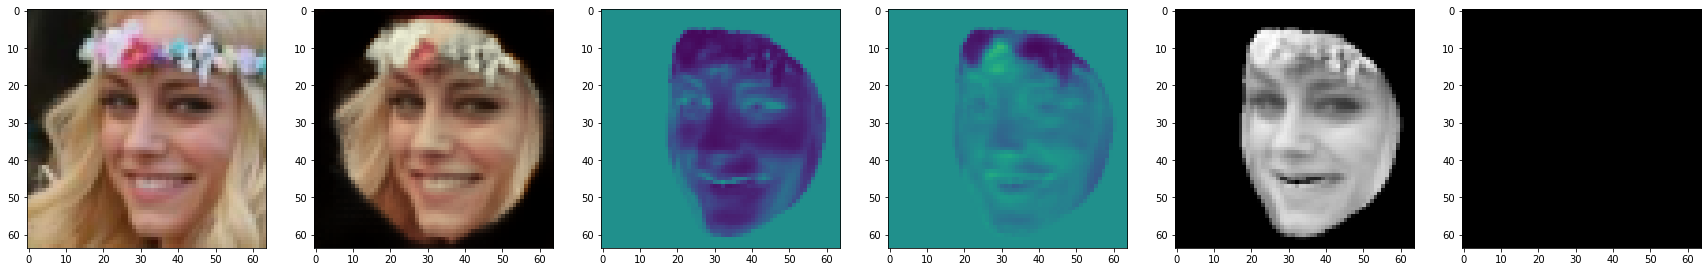

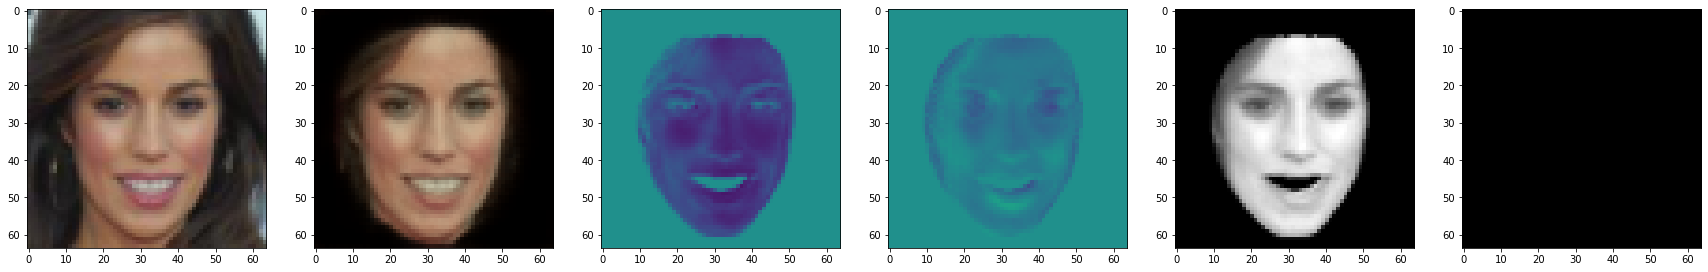

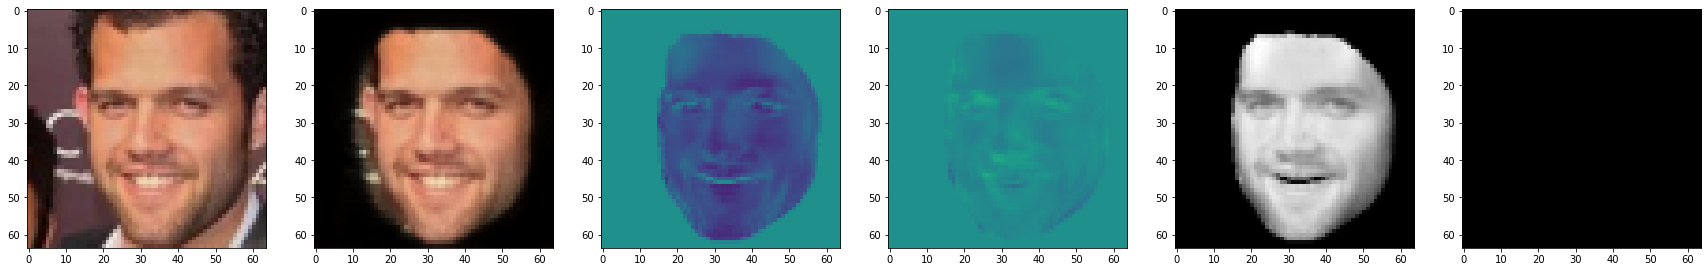

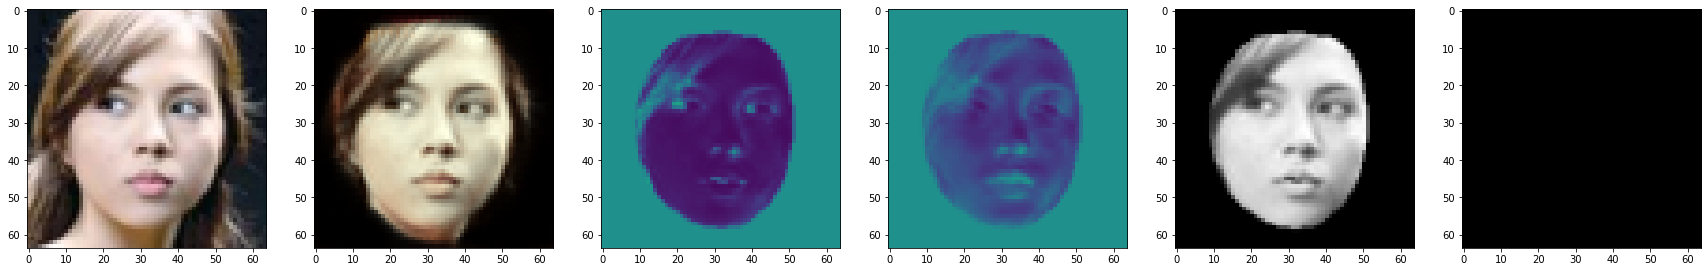

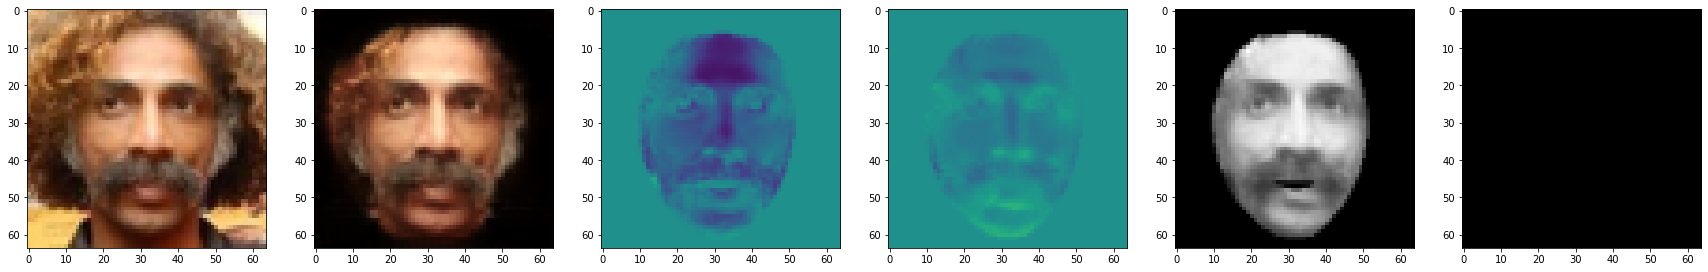

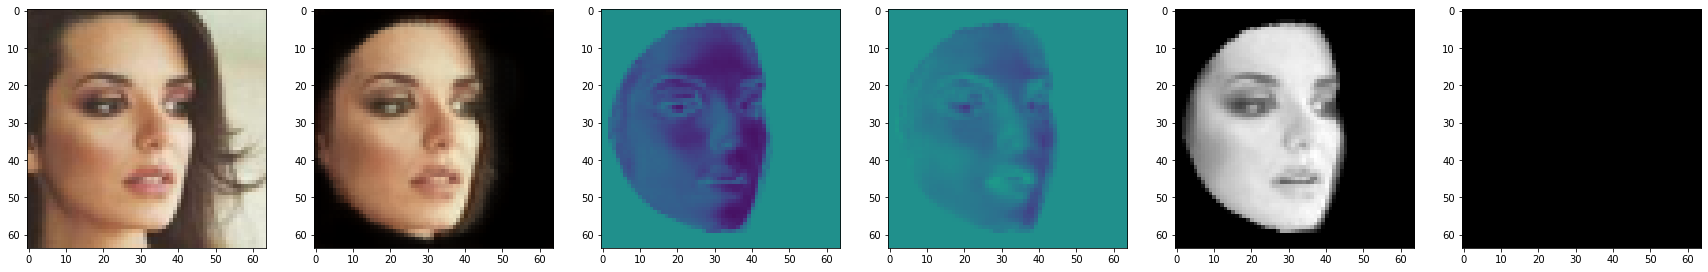

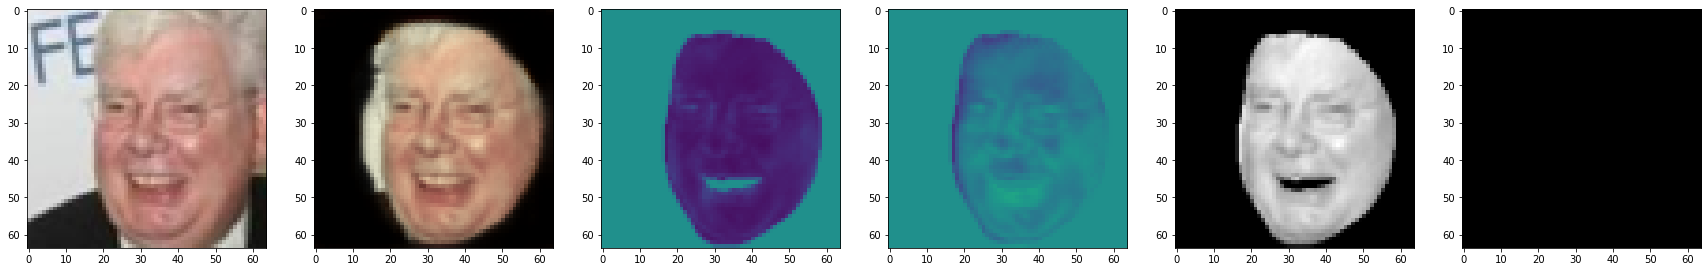

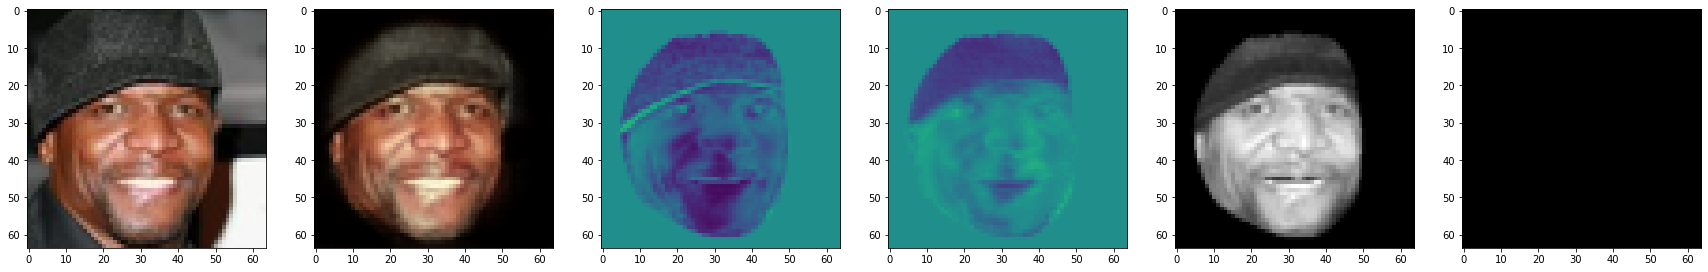

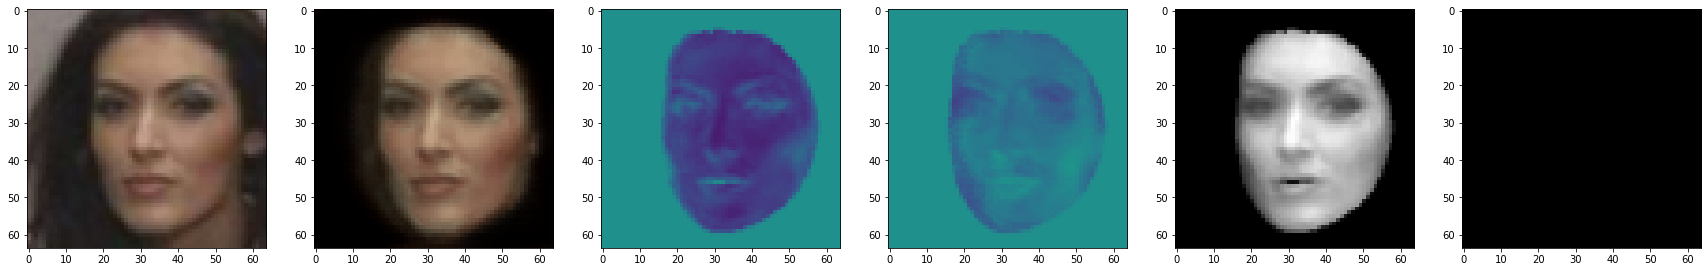

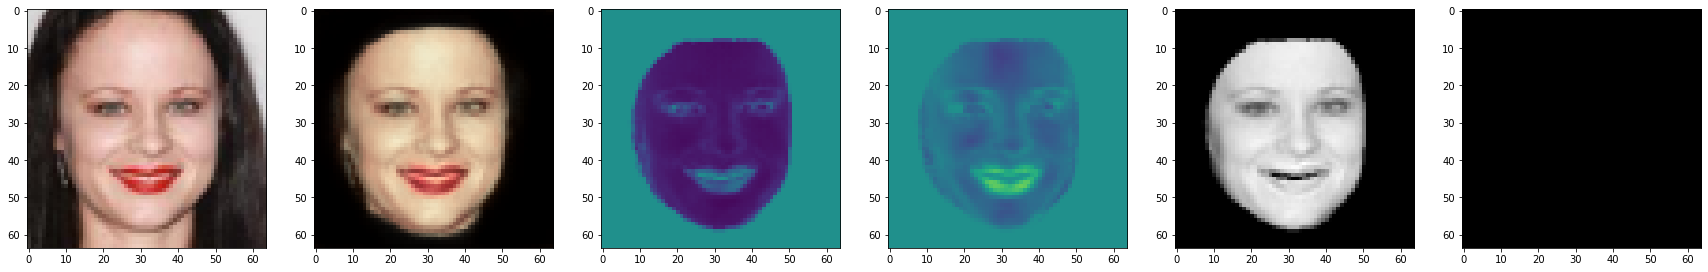

In [128]:
fmel_change = 0
fblood_change = 0
trypredict(parameterpath,dataset.images[10:20],dataset.actualmasks[10:20])

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


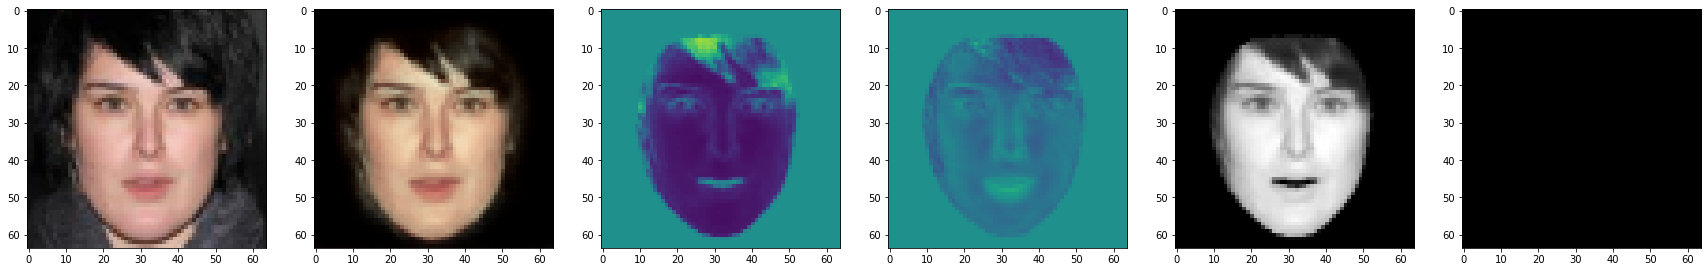

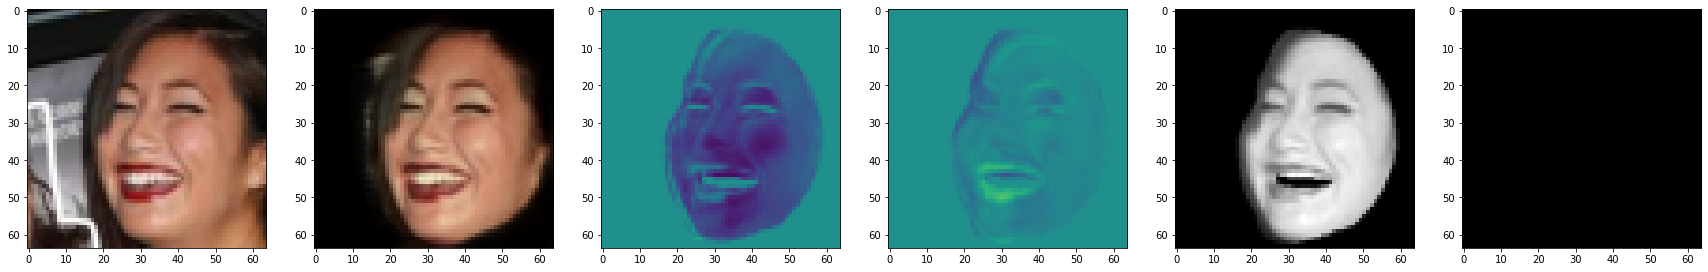

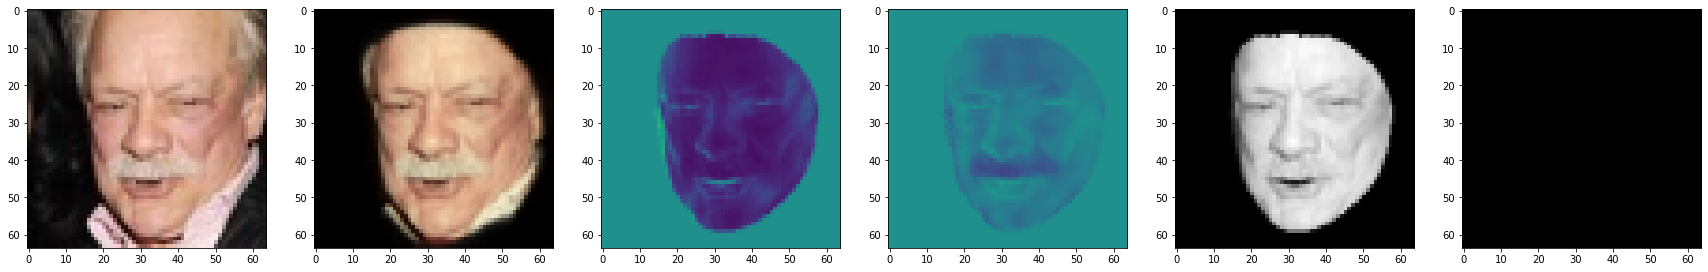

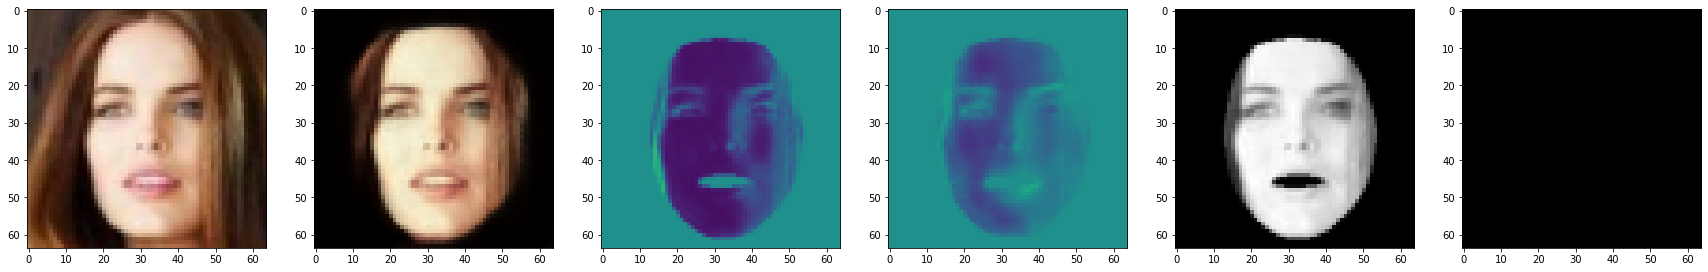

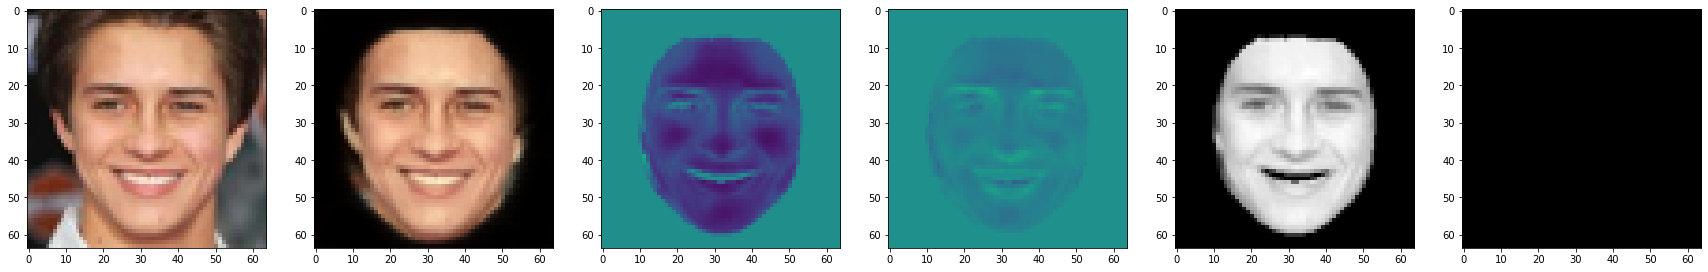

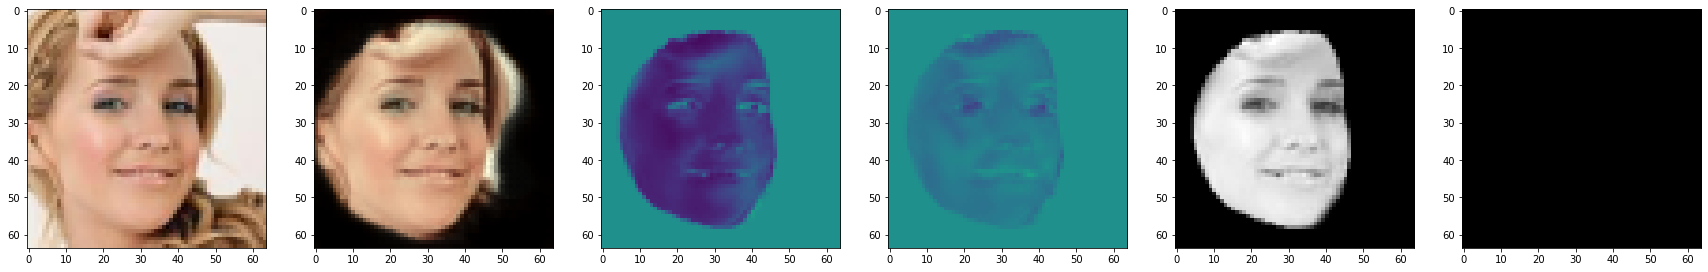

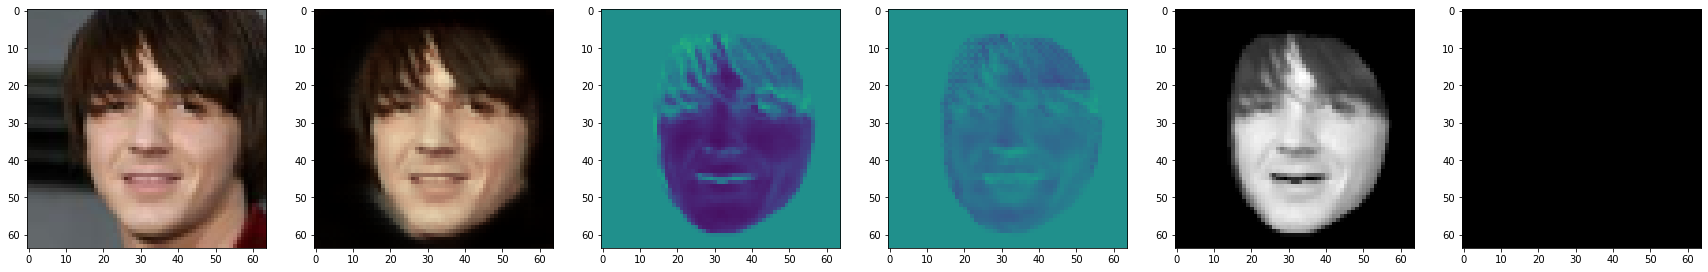

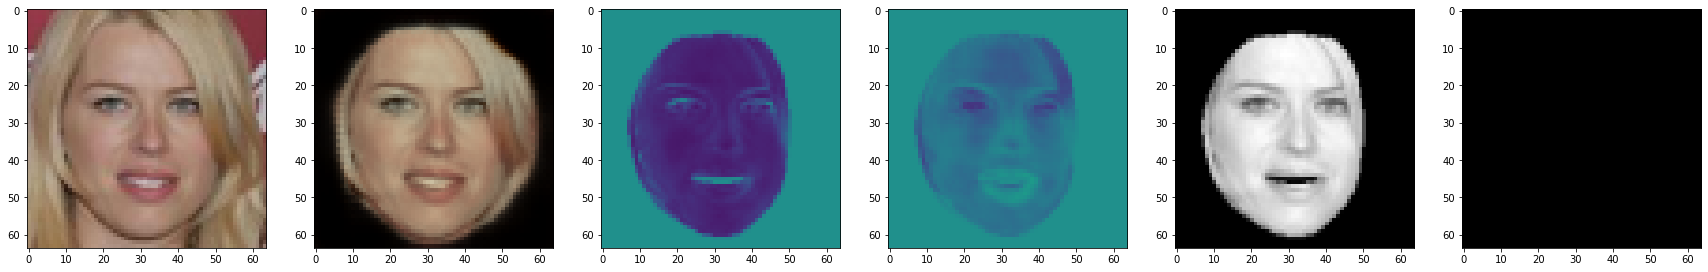

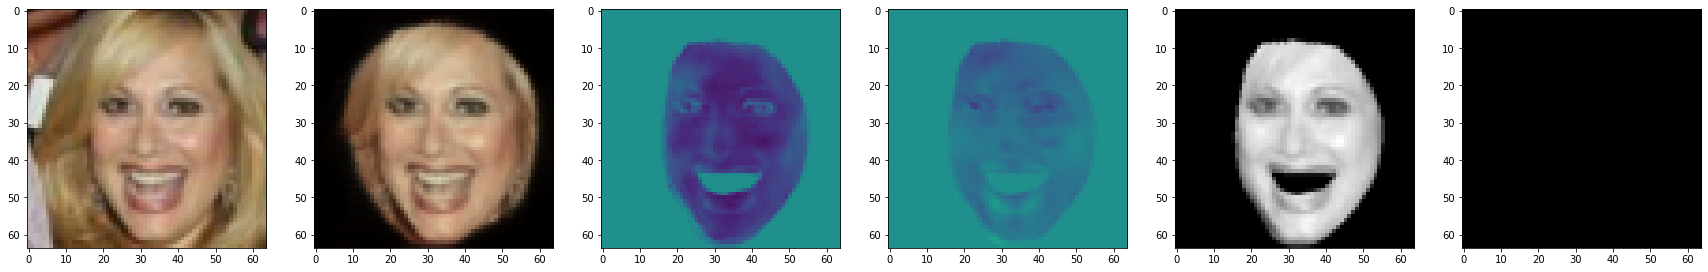

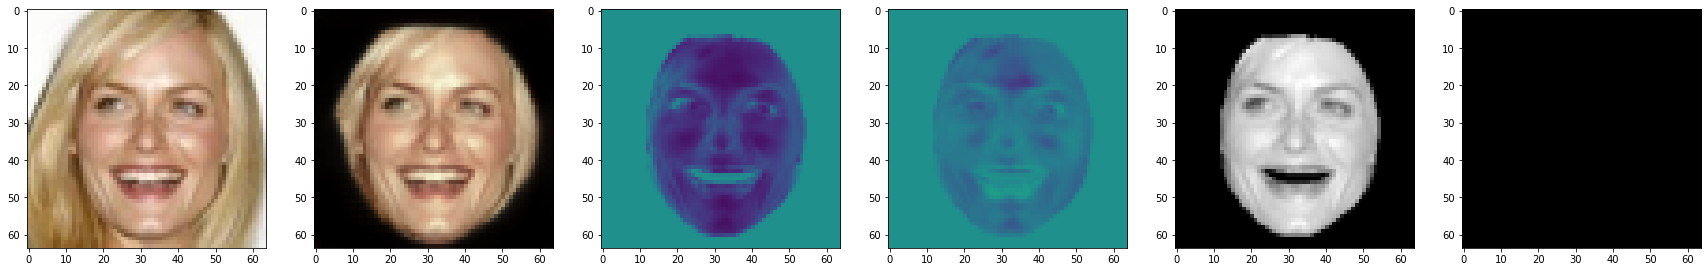

In [123]:
fmel_change = 0
fblood_change = 0
trypredict(parameterpath,dataset.testimages[0:10],dataset.testmasks[0:10])

In [38]:
#trainmodel(B,dataset,num_epochs,matdir,clonedir,load_model(parameterpath))

epochloss tensor(1.5262, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.5171, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.5125, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.5073, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4963, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4894, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4823, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4759, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4687, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4628, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4558, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4507, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4448, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4377, device='cuda:0', grad_fn=<AddBackward0>)
epochloss tensor(1.4345, device='cuda:0', grad_fn=<AddBackward0>)
epochloss 